In [220]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, AveragePooling2D, Input
from keras.optimizers import Adam
from statistics import mean
import tensorflow as tf
import cv2
from keras.models import model_from_json
import numpy as np
from matplotlib import pyplot as plt


In [221]:
train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                    #rotation_range=30,
                                    #shear_range=0.3,
                                    #zoom_range=0.3,
                                    #horizontal_flip=True,
                                    #fill_mode='nearest'
                                   )
test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                    #rotation_range=30,
                                    #shear_range=0.3,
                                    #zoom_range=0.3,
                                    #horizontal_flip=True,
                                    #fill_mode='nearest'
                                    )

train_generator = train_data_generator.flow_from_directory(
    'data/train',
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical')

validation_generator = test_data_generator.flow_from_directory(
        'data/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

num_training_samples = train_generator.n
num_validation_samples = validation_generator.n
batch_size = 64


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [222]:
#Initialize our facial emotion recognition model
FER_CNN = Sequential()

#Add the input dimensions
FER_CNN.add(Input(shape=(48,48,1)))

#Add two convolutional layers with kernel size 5, and relu activation
FER_CNN.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
FER_CNN.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
#Add a max pooling layer to reduce noise, with kernel 2
FER_CNN.add(MaxPooling2D(pool_size=(2, 2)))
#Add a dropout layer with rate 0.25 to reduce risk of overfitting
FER_CNN.add(Dropout(0.25))
 
#Two convolutional layers with kernel size 5 and activation relu
#followed by two maxpooling layers with kernel 2 (to reduce noise)
FER_CNN.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
FER_CNN.add(MaxPooling2D(pool_size=(2, 2)))
FER_CNN.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
FER_CNN.add(MaxPooling2D(pool_size=(2, 2)))
#Dropout layer to reduce risk of overfitting, rate of 0.25
FER_CNN.add(Dropout(0.25))
 
#Final linear layers with final dropout layer with rate 0.25
FER_CNN.add(Flatten())
#FER_CNN.add(Dense(1024, activation='relu'))
FER_CNN.add(Dropout(0.25))
#Softmax function to give probabilistic distribution to each class
FER_CNN.add(Dense(7, activation='softmax'))
 
#See our model architecture:
FER_CNN.summary()
 
 
learning_rate = 0.001

#Choose our optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
FER_CNN.compile(loss='categorical_crossentropy', optimizer=optimizer, 
                      metrics=['accuracy'])

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_131 (Conv2D)             │ (None, 44, 44, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_132 (Conv2D)             │ (None, 40, 40, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_133 (Conv2D)             │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_134 (Conv2D)             │ (None, 4, 4, 128)      │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199,239 (4.57 MB)

 Trainable params: 1,199,239 (4.57 MB)

 Non-trainable params: 0 (0.00 B)

In [223]:
emotion_model_info = FER_CNN.fit(
    train_generator,
    steps_per_epoch=28709 // 64,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=7178 // 64
)

Epoch 1/15


/Users/timothytaylor/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 100s 222ms/step - accuracy: 0.2427 - loss: 1.8727 - val_accuracy: 0.3795 - val_loss: 1.6024
Epoch 2/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 76us/step - accuracy: 0.4219 - loss: 0.8002 - val_accuracy: 0.3000 - val_loss: 0.9625
Epoch 3/15


2024-03-23 19:36:32.166964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/timothytaylor/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-23 19:36:32.186209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


448/448 ━━━━━━━━━━━━━━━━━━━━ 99s 220ms/step - accuracy: 0.3973 - loss: 1.5514 - val_accuracy: 0.4856 - val_loss: 1.3398
Epoch 4/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 47us/step - accuracy: 0.4219 - loss: 0.7261 - val_accuracy: 0.4000 - val_loss: 0.6091
Epoch 5/15


2024-03-23 19:38:11.037636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-23 19:38:11.051797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


448/448 ━━━━━━━━━━━━━━━━━━━━ 96s 214ms/step - accuracy: 0.4918 - loss: 1.3239 - val_accuracy: 0.5117 - val_loss: 1.2755
Epoch 6/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 42us/step - accuracy: 0.4375 - loss: 0.6833 - val_accuracy: 0.6000 - val_loss: 0.4875
Epoch 7/15


2024-03-23 19:39:47.435755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-23 19:39:47.448878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


448/448 ━━━━━━━━━━━━━━━━━━━━ 96s 214ms/step - accuracy: 0.5423 - loss: 1.2012 - val_accuracy: 0.5645 - val_loss: 1.1557
Epoch 8/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 41us/step - accuracy: 0.3906 - loss: 0.6310 - val_accuracy: 0.7000 - val_loss: 0.4361
Epoch 9/15


2024-03-23 19:41:23.839482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-23 19:41:23.852920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


448/448 ━━━━━━━━━━━━━━━━━━━━ 99s 220ms/step - accuracy: 0.5777 - loss: 1.1144 - val_accuracy: 0.5702 - val_loss: 1.1296
Epoch 10/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 45us/step - accuracy: 0.6719 - loss: 0.4621 - val_accuracy: 0.6000 - val_loss: 0.5058
Epoch 11/15


2024-03-23 19:43:02.836817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-23 19:43:02.850742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


448/448 ━━━━━━━━━━━━━━━━━━━━ 99s 221ms/step - accuracy: 0.5968 - loss: 1.0592 - val_accuracy: 0.5774 - val_loss: 1.1231
Epoch 12/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 48us/step - accuracy: 0.6562 - loss: 0.4693 - val_accuracy: 0.5000 - val_loss: 0.6705
Epoch 13/15


2024-03-23 19:44:42.131129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-23 19:44:42.145644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


448/448 ━━━━━━━━━━━━━━━━━━━━ 101s 224ms/step - accuracy: 0.6272 - loss: 0.9979 - val_accuracy: 0.5845 - val_loss: 1.1147
Epoch 14/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 45us/step - accuracy: 0.5781 - loss: 0.4994 - val_accuracy: 0.2000 - val_loss: 1.0342
Epoch 15/15


2024-03-23 19:46:22.960805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-23 19:46:22.974302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


448/448 ━━━━━━━━━━━━━━━━━━━━ 97s 216ms/step - accuracy: 0.6502 - loss: 0.9426 - val_accuracy: 0.5961 - val_loss: 1.1132


In [234]:
FER_CNN.evaluate(validation_generator)
train_accuracy = emotion_model_info.history['accuracy']
validation_accuracy = emotion_model_info.history['val_accuracy']
loss = emotion_model_info.history['loss']

max_val_accuracy = max(validation_accuracy)
print("Test Accuracy: ", max_val_accuracy)
print("Training Accuracy: ", max(train_accuracy))

overall_accuracies = []
for i in range(len(train_accuracy)):
    overall_accuracies.append((train_accuracy[i]*28709 + validation_accuracy[i]*7178) / (28709+7178))
print("Overall Accuracy: ", max(overall_accuracies))

NameError: name 'FER_CNN' is not defined

NameError: name 'train_accuracy' is not defined

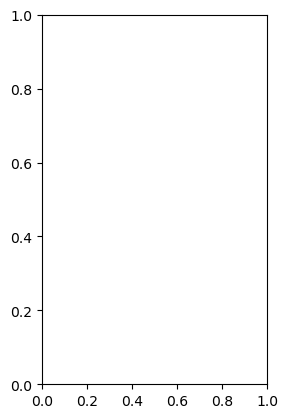

In [233]:
import matplotlib.pyplot as plt
 
# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
 
# loss graph
plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
 
plt.show()